# <center>Twittanalysis Exploration

<center><img src='https://logodownload.org/wp-content/uploads/2014/09/twitter-logo-1-1.png' height='10%' width='10%' ></center>

<center> This notebook is intended to be a exploratory data analysis on my tweeting behavior and related stuff. </center>

<center> You can replicate this notebook getting you own twitter data - steps on how to available <a href='https://t.co/Rkuu2p1wVs'>here</a>. </center>

<center> Follow me on twitter at <a href='https://twitter.com/boanoitegabs'>@boanoitegabs</a>!</center>


In [2]:
from PIL import Image
# from fbprophet import Prophet
from sklearn import preprocessing
from datetime import datetime, timedelta
from wordcloud import WordCloud, ImageColorGenerator

import nltk
import json
import pytz
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
import warnings
warnings.filterwarnings('ignore')

## 1. Meet and Greet with the data

### 1.1 Reading the tweet.js file

As the _readme_ file says: 

_"Tweets posted to account. This record contains the API output of Tweets for this account. Definitions for each of the variables that may be included in any particular Tweet are available in our API documentation: https://developer.twitter.com/en/docs/tweets/post-and-engage/api-reference/post-statuses-update "

In [3]:
tweets_path = 'data/tweet.js'

with open(tweets_path) as dataFile:
    data = dataFile.read()
    obj = data[data.find('{') : data.rfind('}')+1]

raw_tweets = obj.split('\n}, {\n')

In [4]:
tweets_json = []

# Loading first and last raw tweet.
tweets_json.append(json.loads(raw_tweets[0] + '}'))
tweets_json.append(json.loads('{' + raw_tweets[-1]))

# Loading every other tweet.
for raw_tweet in raw_tweets[1:len(raw_tweets)-1]:
    tweet = json.loads('{' + raw_tweet + '\n}')
    tweets_json.append(tweet)
    
print(len(tweets_json), 'tweets tweeted!')

1801 tweets tweeted!


Great! It checks out with my account value. Now let's check one of the tweets to take a look.

In [5]:
tweets_json[np.random.randint(0, len(tweets_json))]

{'retweeted': False,
 'source': '<a href="https://mobile.twitter.com" rel="nofollow">Twitter Web App</a>',
 'entities': {'hashtags': [],
  'symbols': [],
  'user_mentions': [{'name': 'soft universe',
    'screen_name': 'sommerfugl_',
    'indices': ['0', '12'],
    'id_str': '3438527027',
    'id': '3438527027'}],
  'urls': []},
 'display_text_range': ['0', '75'],
 'favorite_count': '1',
 'in_reply_to_status_id_str': '1109563509958983681',
 'id_str': '1109564353710313472',
 'in_reply_to_user_id': '3438527027',
 'truncated': False,
 'retweet_count': '0',
 'id': '1109564353710313472',
 'in_reply_to_status_id': '1109563509958983681',
 'created_at': 'Sat Mar 23 21:15:31 +0000 2019',
 'favorited': False,
 'full_text': '@sommerfugl_ nunca fui lá, topo\n\nsó dizer quando que eu convido os migo sim',
 'lang': 'pt',
 'in_reply_to_screen_name': 'sommerfugl_',
 'in_reply_to_user_id_str': '3438527027'}

All of the available keys of the load can be seen [here](https://developer.twitter.com/en/docs/tweets/post-and-engage/api-reference/post-statuses-update).

### 1.3 Creating pandas dataframes with data

In [6]:
tweets = pd.DataFrame()

# Getting timestamp of the tweet! Here we convert the string into datetime and change its timezone from UTC to BRT. 
date_format = '%a %b %d %H:%M:%S %z %Y'
tweets.loc[:,'created_at'] = [datetime.strptime(tweet['created_at'], date_format).astimezone(pytz.timezone('America/Sao_Paulo')) for tweet in tweets_json]

# Mobile? Desktop? Let's check that!
tweets.loc[:,'source'] = [tweet['source'] for tweet in tweets_json]

# Favorited or retweeted? How many times?
tweets.loc[:,'favorited'] = [tweet['favorited'] for tweet in tweets_json]
tweets.loc[:,'retweeted'] = [tweet['retweeted'] for tweet in tweets_json]
tweets.loc[:,'favorite_count'] = pd.Series([tweet['favorite_count'] for tweet in tweets_json]).astype(int)
tweets.loc[:,'retweet_count'] = pd.Series([tweet['retweet_count'] for tweet in tweets_json]).astype(int)

# And what I tweeted? 
tweets.loc[:,'full_text'] = [tweet['full_text'] for tweet in tweets_json]

# If it is a reply, who he/she is?
tweets.loc[:,'in_reply_to_screen_name'] = [tweet['in_reply_to_screen_name'] if 'in_reply_to_screen_name' in tweet else np.NaN for tweet in tweets_json]

In [7]:
# Sorting by created at timestamp
tweets = tweets.sort_values('created_at').reset_index(drop=True)

# Just giving it a unique ID
tweets.loc[:,'tweet_id'] = np.arange(0, tweets.shape[0])

In [8]:
tweets.head()

,created_at,source,favorited,retweeted,favorite_count,retweet_count,full_text,in_reply_to_screen_name,tweet_id
0,2018-04-03 01:18:46-03:00,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",False,False,1,0,décima terceira vez que eu volto pro twitter p...,NaN,0
1,2018-04-03 01:21:20-03:00,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",False,False,1,0,@dinotefauro é tipo o Mr. Peanutbutter do Boja...,dinotefauro,1
2,2018-10-07 01:42:13-03:00,"<a href=""http://twitter.com/download/android"" ...",False,False,1,0,mais de 6 anos que tenho Twitter e nunca conse...,NaN,2
3,2018-10-07 01:42:50-03:00,"<a href=""http://twitter.com/download/android"" ...",False,False,4,0,resolvi aparecer por aqui só pra dizer que tô ...,NaN,3
4,2018-10-07 01:53:39-03:00,"<a href=""http://twitter.com/download/android"" ...",False,False,1,0,@lew_ax Tabata melhor pessoa &lt;3,lew_ax,4


Ok, let's work with that!

## 2. Exploratory Data Twittanalysis

### 2.1 Date and Time

In [9]:
print('I first tweeted at:')
print(f'\t{tweets.created_at.min().strftime("%d %B %Y")}')

I first tweeted at:
	03 April 2018


In [10]:
tweets.created_at.apply(lambda x: x.strftime('%Y/%m')).value_counts().sort_index()

2018/04      2
2018/10    189
2018/11    174
2018/12    153
2019/01    275
2019/02    236
2019/03    187
2019/04    309
2019/05    276
Name: created_at, dtype: int64

Since April 2018 has only two tweets, i'm gonna drop then so the time series is overall continous.

In [11]:
min_dt_filter = '2018/10'

tweets = tweets[tweets.created_at.apply(lambda x:x.strftime('%Y/%m')) >= min_dt_filter]

In [12]:
def round_it(n):
    a = (n // 10) * 10
    b = a + 10
    return (b if n - a > b else a)

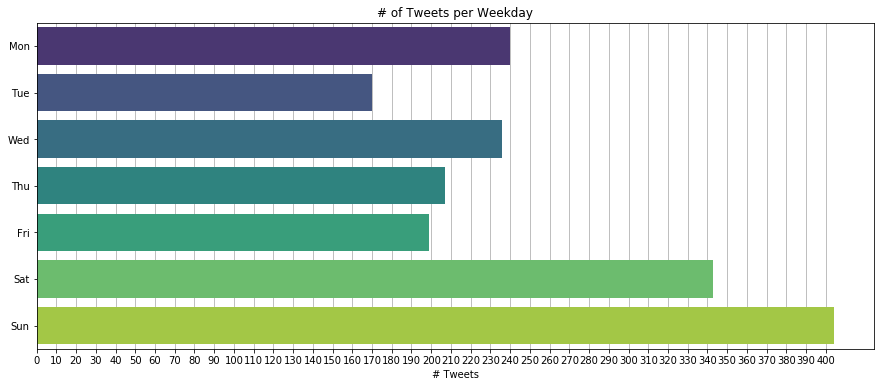

In [13]:
tweets.loc[:,'weekday'] = tweets.created_at.apply(lambda x: x.strftime('%a'))

weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

plt.rc('axes', axisbelow=True)
plt.figure(figsize=(15,6))
plt.title('# of Tweets per Weekday')
plt.grid(axis='x')
sns.countplot(y='weekday', 
              palette='viridis',
              data=tweets,
              order=weekdays)
plt.xticks(np.arange(0, round_it(tweets.groupby('weekday').tweet_id.count().max()) + 1, 10))
plt.ylabel('')
plt.xlabel('# Tweets')
plt.show()

As expected, the days I most tweet are Saturday and Sunday. Tuesday and Thursdays are the days I least tweeted, given they are usually my busiest days, it makes sense. :)

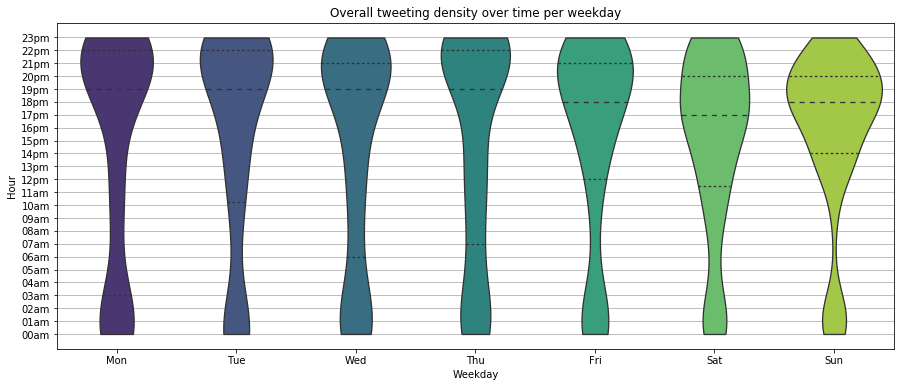

In [14]:
plt.figure(figsize=(15,6))
sns.violinplot(data=tweets,
               x='weekday', 
               y=tweets.created_at.apply(lambda x: x.hour), 
               cut=0,
               order=weekdays,
               inner="quart",
               palette='viridis',
               linewidth=1.3)
plt.ylabel('Hour')
plt.xlabel('Weekday')
plt.title('Overall tweeting density over time per weekday')
plt.yticks(ticks=np.arange(0, 24, 1), labels=[str(n).zfill(2) + 'am' if n < 12 else str(n).zfill(2) + 'pm' for n in np.arange(0, 24, 1)])
plt.grid(axis='y')
plt.show()

This plot is mixing vacations and no vacations tweeting time. Let's check their difference.

In [15]:
vacations_started_at = '2018-12-08'
vacations_ended_at = '2019-02-18'

tweets.loc[:,'vacations'] = tweets.created_at.apply(lambda x: 'On Vacations' if vacations_started_at <= str(x) <= vacations_ended_at else 'Not on Vacations')
tweets.vacations.value_counts()

Not on Vacations    1247
On Vacations         552
Name: vacations, dtype: int64

The data is well split between vacations and not vacations, good!

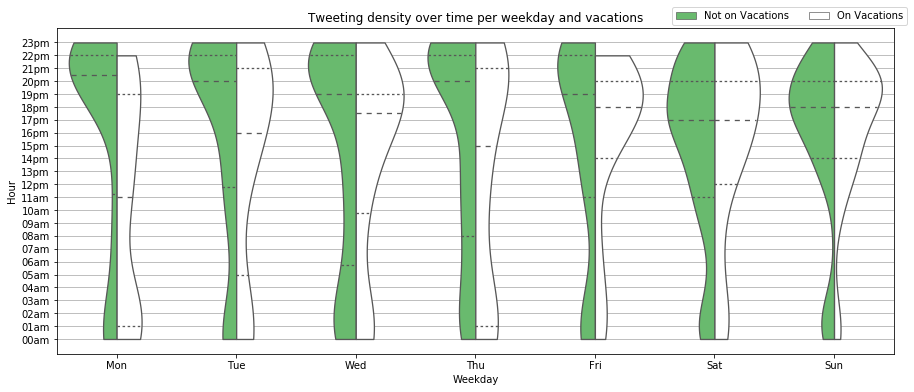

In [16]:
plt.figure(figsize=(15,6))
sns.violinplot(data=tweets,
               x='weekday', 
               y=tweets.created_at.apply(lambda x: x.hour), 
               hue="vacations",
               cut=0,
               split=True,
               order=weekdays,
               palette={
                   'On Vacations': 'white',
                   'Not on Vacations': '#5BC862'},
               inner="quart", 
               linewidth=1.3)
plt.ylabel('Hour')
plt.xlabel('Weekday')
plt.title('Tweeting density over time per weekday and vacations')
plt.yticks(ticks=np.arange(0, 24, 1), labels=[str(n).zfill(2) + 'am' if n < 12 else str(n).zfill(2) + 'pm' for n in np.arange(0, 24, 1)])
plt.legend(loc='upper center', bbox_to_anchor=(0.875, 1.08), ncol=2)
plt.grid(axis='y')
plt.show()

As predicted, my tweeting behavior over time of the day is very different on each cluster.

Now, let's make some visualizations over the time series.

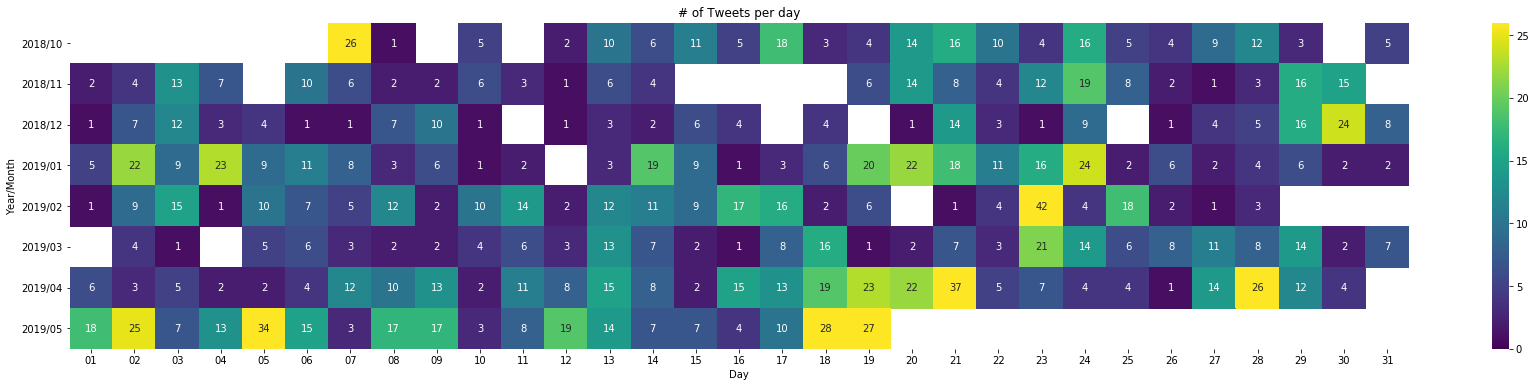

In [17]:
tweets.loc[:,'month/year'] = tweets.created_at.apply(lambda x: x.strftime('%Y/%m'))
tweets.loc[:,'day'] = tweets.created_at.apply(lambda x: x.strftime('%d'))

plt.figure(figsize=(30, 6))
hm = sns.heatmap(
    pd.crosstab(
        index=tweets['month/year'], 
        columns=tweets['day'],
        values=tweets['tweet_id'],
        aggfunc='count'
        ),
    annot=True,
    cmap='viridis',
    vmin=0,
    vmax=26 # We have the 42 tweets day outlier, we don't want it ruinning our vis.
)
plt.title('# of Tweets per day')
plt.xlabel('Day')
plt.yticks(rotation=0)
plt.ylabel('Year/Month')
plt.show()

- In my first serious day around here I tweeted a lot - there were 26 tweets on the same day.  
- Since the first day I seriously engaged with Twitter (Oct/26) I've only spent 4 days without tweeting (Nov/15 ~ Nov/18) - it really is addictive!.
- 42 Tweets on Feb/23. Holy cow. I procrastinated hard that day.

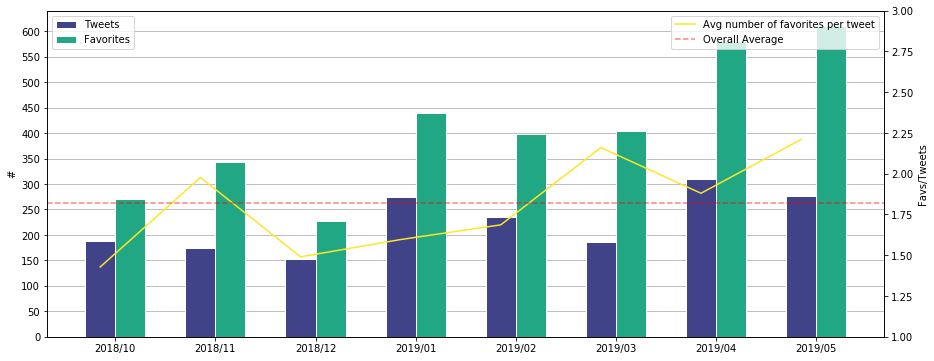

In [18]:
a = tweets.groupby('month/year').tweet_id.count().values
b = tweets.groupby('month/year').favorite_count.sum().values

barwidth = 0.3
r1 = np.arange(len(a))
r2 = [x+barwidth for x in r1]

fig, ax1 = plt.subplots(figsize=(15,6))

ax1.bar(r1, a, color='#404387', width=barwidth, edgecolor='white', label='Tweets')
ax1.bar(r2, b, color='#22A784', width=barwidth, edgecolor='white', label='Favorites')
ax1.set_ylabel('#')
ax1.set_yticks(np.arange(0, b.max() + 1, 50))
ax1.legend(loc='upper left')
ax1.grid(axis='y')

ax2 = ax1.twinx()
ax2.plot(tweets['month/year'].unique(), b/a, label='Avg number of favorites per tweet', color='#FDE724')
ax2.axhline(sum(b)/sum(a), linestyle='dashed', alpha=.5, color='red', label='Overall Average')
ax2.set_ylabel('Favs/Tweets')
ax2.set_ylim(1, 3)
ax2.legend(loc='upper right')

plt.xticks([r+barwidth/2 for r in range(len(a))], tweets['month/year'].unique())
plt.xlabel('Year/Month')
plt.show()

### 2.2 Text and People

In [19]:
tweets.full_text.head()

2    mais de 6 anos que tenho Twitter e nunca conse...
3    resolvi aparecer por aqui só pra dizer que tô ...
4                   @lew_ax Tabata melhor pessoa &lt;3
5    queria não ter deletado todos meus tweets anti...
6    É muito difícil achar pessoas aqui e distingui...
Name: full_text, dtype: object

In [20]:
tweets.loc[:, 'tmp_count'] = tweets.full_text.apply(lambda x: x.count(','))

#### What are the words I most use?

In [21]:
# Listing stopwords I don't want to appear in the text
stopwords = nltk.corpus.stopwords.words('portuguese')

# Don't want to see the users
users = list(tweets.in_reply_to_screen_name.dropna().unique())
stopwords += users

# Self-made list
self_list = ['pra', 'https', 'co', 'lá', 'RT']
stopwords += self_list

In [22]:
words = ' '.join(tweets.full_text)

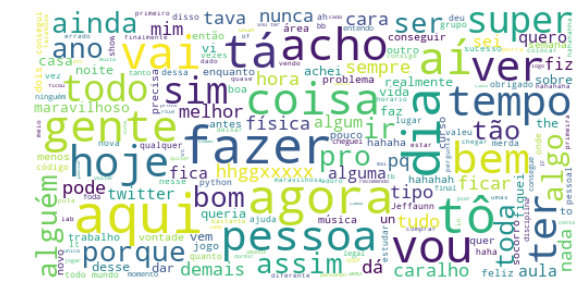

In [23]:
wordcloud = WordCloud(
    stopwords=stopwords, 
    max_font_size=50, 
    background_color='white',
    width=500, 
    height=250).generate(words)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#### What about replying?

In [24]:
was_reply = tweets.in_reply_to_screen_name.isna().value_counts().sort_index()

In [25]:
print("Of all my {} tweets, {} were replies, and {} weren't.".format(tweets.shape[0], was_reply[True], was_reply[False]))

Of all my 1799 tweets, 699 were replies, and 1100 weren't.


In [26]:
# Masking the users so I don't expose anyone in any way.
le = preprocessing.LabelEncoder()
reply_tweets = tweets.dropna()

In [27]:
masked_users = le.fit(reply_tweets.in_reply_to_screen_name).transform(reply_tweets.in_reply_to_screen_name)
reply_tweets.loc[:,'masked_screen_name'] = ['User ' + str(code) for code in masked_users]

In [28]:
filter_time = False
show_top = 20

if filter_time:
    show_after = '2019-01-01'
    reply_tweets_plot = reply_tweets[reply_tweets.created_at >= '2019-01-01'].copy()
else:
    reply_tweets_plot = reply_tweets.copy()

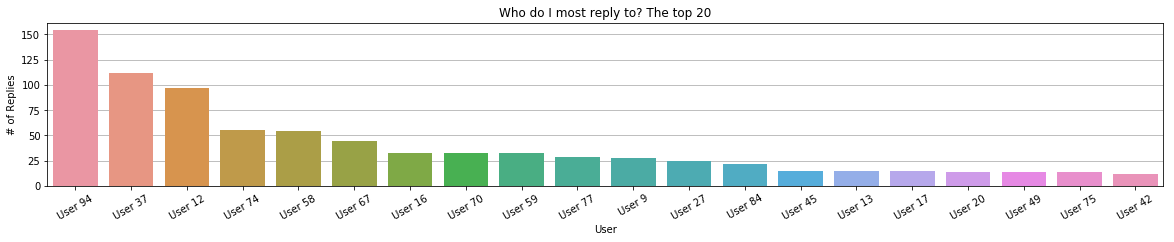

In [29]:
plt.rc('axes', axisbelow=True)
plt.figure(figsize=(20, 3))
plt.title('Who do I most reply to? The top {}'.format(show_top))
sns.barplot(
    x=reply_tweets_plot.masked_screen_name.value_counts()[:show_top].index, 
    y=reply_tweets_plot.masked_screen_name.value_counts()[:show_top],
)
plt.ylabel('# of Replies')
plt.xticks(rotation=30)
plt.xlabel('User')
plt.grid(axis='y')
plt.show()

### 2.3 Sources

Let's check out the main sources that I tweet on! :)

In [30]:
tweets.loc[:,'source'] = tweets.source.apply(lambda x: x.split('>')[1].split('<')[0])

In [31]:
print('Unique Source Values:')
tweets.source.value_counts()

Unique Source Values:


Twitter for Android    833
Twitter Web App        603
Twitter Web Client     360
Curious Cat              3
Name: source, dtype: int64

As said on https://freshvanroot.com/blog/2019/twitter-redesign-2019-newtwitter/:

"_Only in the end of January 2018 they renamed 'Twitter Lite' to 'Twitter Web App'. The 'old' desktop web interface is called 'Twitter Web Client'._"

Therefore, we can aggregate "Twitter Web Client and Twitter Web App as desktop and "Twitter for Android" as mobile.

In [32]:
tweets.loc[:,'source'] = tweets.source.map({
    'Twitter for Android':'Mobile'
}).fillna('Desktop')

In [33]:
print('Desktop: {0:.2%}'.format(tweets.source.value_counts()[0]/tweets.source.count()))
print('Mobile : {0:.2%}'.format(tweets.source.value_counts()[1]/tweets.source.count()))

Desktop: 53.70%
Mobile : 46.30%


I tweet just a little more on desktop, but it's a pretty fair distribution.

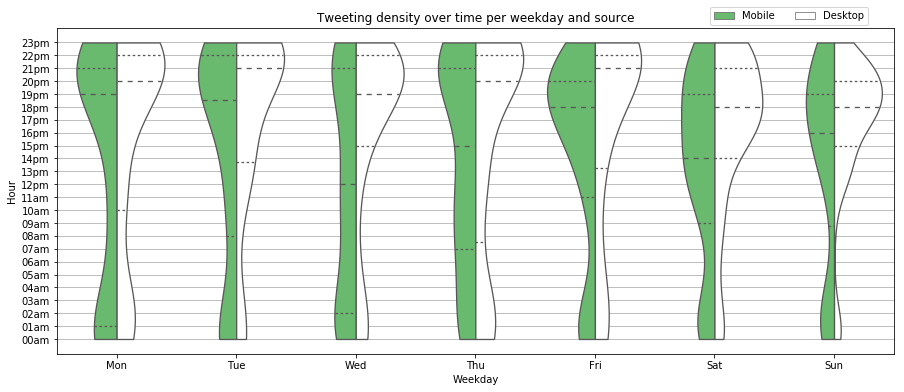

In [34]:
plt.figure(figsize=(15,6))
sns.violinplot(data=tweets,
               x='weekday', 
               y=tweets.created_at.apply(lambda x: x.hour), 
               hue="source",
               cut=0,
               split=True,
               order=weekdays,
               palette={
                   'Desktop': 'white',
                   'Mobile': '#5BC862'},
               inner="quart", 
               linewidth=1.3)
plt.ylabel('Hour')
plt.xlabel('Weekday')
plt.title('Tweeting density over time per weekday and source')
plt.yticks(ticks=np.arange(0, 24, 1), labels=[str(n).zfill(2) + 'am' if n < 12 else str(n).zfill(2) + 'pm' for n in np.arange(0, 24, 1)])
plt.legend(loc='upper center', bbox_to_anchor=(0.875, 1.08), ncol=2)
plt.grid(axis='y')
plt.show()

## 3. Making some predictions

In [35]:
tweets_cumsum = tweets.groupby(tweets.created_at.apply(lambda x: x.date)).tweet_id.count().cumsum().reset_index()
tweets_cumsum.columns = ['ds', 'y']

In [36]:
m = Prophet()
m.fit(tweets_cumsum)
future = m.make_future_dataframe(periods=120)
forecast = m.predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [37]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
324,2019-09-12,3284.975043,2984.875486,3589.182440
325,2019-09-13,3295.634504,2992.126694,3610.223122
326,2019-09-14,3312.544035,3005.173486,3627.655839
327,2019-09-15,3329.691817,3019.667183,3654.091799
328,2019-09-16,3341.206811,3025.267711,3670.175021


In [38]:
tweets_cumsum.loc[:, 'ds'] = tweets_cumsum.ds.astype(str)
forecast.loc[:, 'ds'] = forecast.ds.astype(str)

tweets_cumsum = tweets_cumsum.merge(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds', how='outer')

tweets_cumsum.loc[:, 'ds'] = pd.to_datetime(tweets_cumsum.ds)

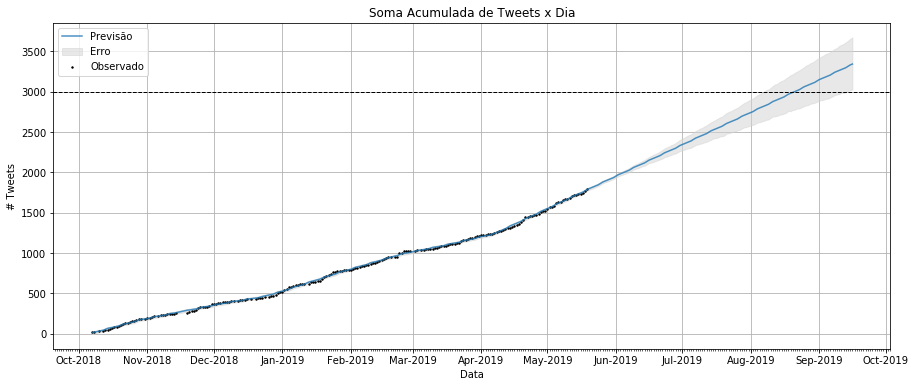

In [39]:
date = tweets_cumsum.ds
yobs = tweets_cumsum.y
yhat = tweets_cumsum.yhat
yhat_lower = tweets_cumsum.yhat_lower
yhat_upper = tweets_cumsum.yhat_upper

fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(date, yhat, alpha=.8, label='Previsão')
ax.fill_between(date, yhat_lower, yhat_upper, alpha=.5, color='lightgray', label='Erro')
ax.scatter(date, yobs, s=2, color='k', label='Observado')

ax.axhline(3000, ls='--', lw=1, color='k')

ax.set_title('Soma Acumulada de Tweets x Dia')
ax.set_xlabel('Data')
ax.set_ylabel('# Tweets')

days = mdates.DayLocator()
months = mdates.MonthLocator() 
fmt = mdates.DateFormatter('%b-%Y')

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(fmt)
ax.xaxis.set_minor_locator(days)

ax.grid()
ax.legend(loc='upper left');